In [10]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import pingouin as pg
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut
import decoder.manifold as mf
from decoder.metrics import get_error

In [11]:
# %% Setup
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': [os.path.join(folder,'Similar5_937_invivo.hdf5'),
                       os.path.join(folder,'Similar6_939_invivo.hdf5'),
                       os.path.join(folder,'Similar7_948_invivo.hdf5'),
                       os.path.join(folder,'Similar8_5454_invivo.hdf5')]}
exps = ['Enriched','Dissimilar','Similar']

In [ ]:
def collect_data(tuning, ctx=np.array([0,1,0,1]), ybin=80):
    
    y_edges = np.linspace(0,4,ybin+1)  # Unify position data to (0,4)
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    Fdata, ydata  = [], []
    for c in range(len(set(ctx))):
        F = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)  # (ncell, ybin, ntrial)
        Fdata.append(np.transpose(F, (2,1,0)))  # (ntrial, ybin, ncell)
        ydata.append(np.tile(y_centers, (F.shape[2],1)))  # (ntrial, ybin)
        
    return Fdata, ydata

def prepare_data(Fs, ys, trial=None, average=False):
    '''
    Parameters
    ----------
    Fs : numpy array (ntrial, ybin, ncell)
        Spatial tuning of a given mouse with all trials stacked along axis=0
    ys : numpy array (ntrial, ybin)
        Position vector of each trial
    trial : numpy 1d array
        Indices of selected trials
    average : bool
        Whether to average over trials

    Returns
    -------
    X : array (n_samples, ncell)
    y : array (n_samples,)
        where n_samples = ybin if trial-averaged, otherwise n_samples = ntrial*ybin
    '''
    if trial is None:  # Take all trials
        trial = np.arange(Fs.shape[0])
    elif isinstance(trial, int):
        trial = [trial]
    if average:
        X = np.mean(Fs[trial,:,:], axis=0)  # (ybin, ncell)
        y = np.mean(ys[trial,:], axis=0)  # (ybin,)
    else:
        X = np.vstack([Fs[r,:,:] for r in trial])
        y = np.hstack([ys[r,:] for r in trial])
    ## Discard points where all cells are silent
    silent = (X.sum(axis=1) == 0)
    if np.any(silent):
        X = X[~silent,:]
        y = y[~silent]
        
    return X, y

def decode_novel_cv(Fdata, ydata, nfold=10, shuffle=0, y2cm=100, align=True, **kwargs):
    
    X_train_fam, y_train_fam = prepare_data(Fdata[0], ydata[0], trial=None, average=True)  # Familiar context (train)    
    
    ntrial, ybin, ncell = Fdata[1].shape  # Novel context
    if shuffle:  # Non zero integer
        cv = KFold(n_splits=nfold, shuffle=True, random_state=shuffle)
    else:
        cv = KFold(n_splits=nfold, shuffle=False)
    error = []
    
    for train_set, test_set in cv.split(np.zeros((ntrial,1))): 
        
        X_train_nov, y_train_nov = prepare_data(Fdata[1], ydata[1], trial=train_set, average=True)  # Novel context (train)
        X_test_nov, y_test_nov = prepare_data(Fdata[1], ydata[1], trial=test_set, average=False)  # Novel context (test)
    
        spd = mf.SpatialNovelDecoder2(**kwargs)
        spd.fit([X_train_fam, X_train_nov], y_train_fam)
        y_pred = spd.predict(X_test_nov, align=align)
    
        ind = np.isfinite(y_pred)
        if not np.all(ind):
            print('Warning: neglect %d NaN in test data (%.4g%% samples)' % (np.sum(~ind), 100*np.mean(~ind)))
        error.append(y2cm*get_error(y_test_nov[ind], y_pred[ind], kind='median'))
    
    return np.array(error)

def decode_novel_mouse(datapath, day=[1,2,3], min_rate=1/60, ybin=80, ysigma=1, nfold=10, shuffle=0, **kwargs):
    
    data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
    with h5py.File(datapath, 'r') as f:
        yrange = f['params/yrange'][()]  # Dataset dependent
        
    tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                               spike=False, transient=True)
    nday = len(day)
    errors = np.zeros(nday)
    
    for d in range(nday):
        sess = np.where(days==(d+1))[0]
        Fdata, ydata = collect_data([tuning[s] for s in sess], ctx=ctx[sess], ybin=ybin)
        error = decode_novel_cv(Fdata, ydata, nfold=nfold, shuffle=shuffle, y2cm=100, align=True, **kwargs)
        errors[d] = np.mean(error)
        
    return errors

In [ ]:
datapaths = alldata['Enriched'] + alldata['Dissimilar']
day = [1,2,3]
min_rate = 0
ybin = 80
ysigma = 2
nfold = 10
shuffle = 2
params = dict(method='knr', k=10, knr_metric='euclidean', # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
              reduction='umap', dim=6,  # 'none'|'pca'|'umap'   
              n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters

df_list = []
nday = len(day)
errors = np.zeros((len(datapaths),nday))
    
for m, datapath in enumerate(datapaths):

    print('Calculating for mouse %d' % (m+1))
    errors[m] = decode_novel_mouse(
        datapath, day=day, min_rate=min_rate, ybin=ybin, ysigma=ysigma, nfold=nfold, shuffle=shuffle, **params)
        
df = pd.DataFrame(errors, columns=day)

with pd.ExcelWriter('Decode position align day.xlsx') as writer:
    df.to_excel(writer, sheet_name='Align', index=False)

## Plot results

In [12]:
excelfile = r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Decode position align day.xlsx'
day = [1,2,3]

df = pd.read_excel(excelfile, sheet_name='Align')  # (Mouse,Day)
df['Mouse'] = df.index
df_long = pd.melt(df, id_vars='Mouse', value_vars=day, var_name='Day', value_name='Error')
print(df_long)

    Mouse Day   Error
0       0   1  71.675
1       1   1  76.800
2       2   1  62.825
3       3   1  84.650
4       4   1  81.825
5       5   1  74.625
6       6   1  77.300
7       0   2  43.575
8       1   2  73.175
9       2   2  36.250
10      3   2  85.600
11      4   2  67.525
12      5   2  81.300
13      6   2  97.350
14      0   3  47.050
15      1   3  84.225
16      2   3  85.500
17      3   3  75.275
18      4   3  56.750
19      5   3  55.025
20      6   3  63.075


In [13]:
res = pg.rm_anova(data=df_long, dv='Error', within='Day', subject='Mouse')
pg.print_table(res, floatfmt='.4g')


ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc      ng2     eps
--------  -------  -------  ------  -------  -------  ------
Day             2       12  0.6417   0.5435  0.06054  0.7058



In [14]:
post_hoc = pg.pairwise_tests(data=df_long, dv='Error', within='Day', subject='Mouse', parametric=True, padjust='bonf')
pg.print_table(post_hoc, floatfmt='.4g')


POST HOC TESTS

Contrast      A    B  Paired    Parametric         T    dof  alternative      p-unc    p-corr  p-adjust      BF10    hedges
----------  ---  ---  --------  ------------  ------  -----  -------------  -------  --------  ----------  ------  --------
Day           1    2  True      True          0.9611      6  two-sided       0.3736    1       bonf         0.508    0.3638
Day           1    3  True      True          1.328       6  two-sided       0.2323    0.6969  bonf         0.677    0.7113
Day           2    3  True      True          0.244       6  two-sided       0.8154    1       bonf         0.362    0.1257



In [15]:
post_hoc = pg.pairwise_tukey(data=df_long, dv='Error', between='Day')
pg.print_table(post_hoc, floatfmt='.4g')


POST HOC TESTS

  A    B    mean(A)    mean(B)    diff     se       T    p-tukey    hedges
---  ---  ---------  ---------  ------  -----  ------  ---------  --------
  1    2      75.67      69.25   6.418  8.584  0.7477     0.7388    0.3638
  1    3      75.67      66.7    8.971  8.584  1.045      0.559     0.7113
  2    3      69.25      66.7    2.554  8.584  0.2975     0.9525    0.1257



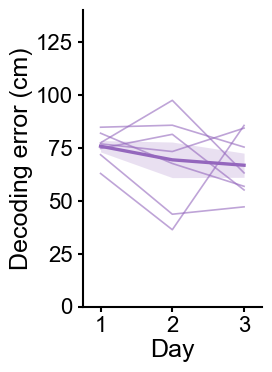

In [16]:
# %% Plot
A = df_long
color = 'tab:purple'
nday = len(set(A['Day']))

fig, ax = plt.subplots(figsize=(3,4))
n_mice = len(set(A['Mouse']))
for m in range(n_mice):
    a = A[A['Mouse']==m]['Error']
    ax.plot(np.arange(1,nday+1), a, c=color, alpha=0.6, lw=1.2)
sns.lineplot(df_long, x='Day', y='Error', color=color, lw=2.4,
             errorbar='se', err_style='band', err_kws=dict(lw=0))
ax.set(xlim=[0.75,3.25], ylim=[0,140], ylabel='Decoding error (cm)')
fig.tight_layout()
# fig.savefig('Decode position align day.svg')